In [1]:
# for interactive slicer
#%matplotlib widget
import tifffile
import os
import matplotlib.pyplot as plt
import tifffile
import numpy as np
import skimage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pumapy as puma
import pyvista as pv
import os
import pandas as pd
import math

'import TexGen.Core' failed (TexGen is only made available when installing puma with conda on UNIX).


In [2]:
def contrast_stretching(input_image):
    #Contrast stretching
    #Dropping extreems (artifacts)
    p2, p98 = np.percentile(input_image, (2, 98))
    stretched_image = skimage.exposure.rescale_intensity(input_image, in_range=(p2, p98))
    return stretched_image.astype('uint8')

In [3]:
def read_and_preprocessing (path, s):
    
    img = tifffile.imread(path)
    img = img[s[0]:s[1],s[2]:s[3],s[4]:s[5]]
    #img = contrast_stretching(img).astype('uint8')
    
    return img
    

In [4]:
snow_files = {'High-res': 'data/registered_image02_3dCT_B40_bag12_13_300mm.tif',
              'Bicubic' : 'data/02_Substack (6267-6662)_B40_bag12_13.tif',
              'SRCNN'   : 'model_output/02_Substack_predictions_SRCNN_.tif',
              'DCSRN'   : 'model_output/02_Substack_predictions_DCSRN_.tif',
              'SRUnet'  : 'model_output/02_Substack_predictions_SRUnet_.tif',
              'SRResnet': 'model_output/02_Substack_predictions_SRResnet_.tif'}

In [5]:
firn_files = {'High-res': 'data/registered_image06_3dCT_B40_bag56_57_100mm.tif',
              'Bicubic' : 'data/06_Substack (8055-8449)_B40_bag56_57.tif',
              'SRCNN'   : 'model_output/06_Substack_predictions_SRCNN_.tif',
              'DCSRN'   : 'model_output/06_Substack_predictions_DCSRN_.tif',
              'SRUnet'  : 'model_output/06_Substack_predictions_SRUnet_.tif',
              'SRResnet': 'model_output/06_Substack_predictions_SRResnet_.tif'}

In [6]:
ice_files = {'High-res': 'data/registered_image10_3dCT_B40_bag108_109_538mm.tif',
              'Bicubic' : 'data/10_Substack (4268-4663)_B40_bag108_109.tif',
              'SRCNN'   : 'model_output/10_Substack_predictions_SRCNN_.tif',
              'DCSRN'   : 'model_output/10_Substack_predictions_DCSRN_.tif',
              'SRUnet'  : 'model_output/10_Substack_predictions_SRUnet_.tif',
              'SRResnet': 'model_output/10_Substack_predictions_SRResnet_.tif'}

In [7]:
snow_slice = [10,410,800,1200,200,600]
firn_slice = [10,410,600,1000,1200,1600]
ice_slice= [10,410,200,600,800,1200]

snow
firn
ice


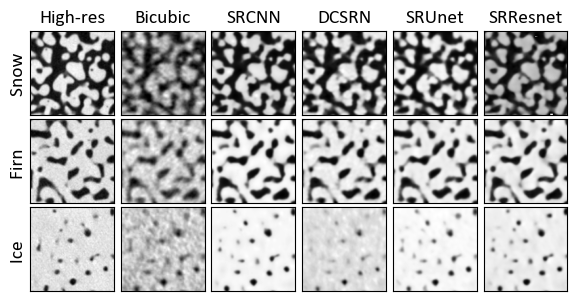

In [8]:
# Create a figure with subplots for displaying multiple images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(7, 5),sharex=True, sharey=True)
i = 12

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for num , f in enumerate([snow_files,firn_files,ice_files]):
    type_ = ['snow','firn','ice'][num]
    print (type_)
    slice_ = [snow_slice,firn_slice,ice_slice][num]
    
    for row_number , name in enumerate(f.keys()):
        row_number = num*6 + row_number
        ax = axes[row_number]
        #print (name)
        #print (row_number)
        data = read_and_preprocessing (f[name], slice_)
        ax.imshow(data[i,:128,:128],'gray', extent=[0, 1, 0, 1])
        #ax.axis('off')  # Turn off axis labels
        ax.set_box_aspect(1)
        ax.yaxis.set_ticks([])
        ax.xaxis.set_ticks([])

        if type_ == 'snow':
            ax.set_title("{}".format(name), fontname='Calibri', fontsize=14)

fig.text(0.1, 0.38, '     Ice              Firn            Snow        ',
         va='center', rotation='vertical', fontfamily='Calibri', fontsize=14)
#plt.tight_layout()  # Adjust layout

fig.subplots_adjust(wspace=0.02, hspace=0.05, top=0.62, bottom=0.1)
plt.savefig('SR_resutls_2D.pdf')
plt.show()

    
    

In [9]:

def contrast_stretching(input_image):
    #Contrast stretching
    #Dropping extreems (artifacts)
    p2, p98 = np.percentile(input_image, (2, 98))
    stretched_image = skimage.exposure.rescale_intensity(input_image, in_range=(p2, p98))
    return stretched_image.astype('uint8')

In [10]:
def read_and_preprocessing (path, s):
    
    img = tifffile.imread(path)
    img = img[s[0]:s[1],s[2]:s[3],s[4]:s[5]]
    img = contrast_stretching(img).astype('uint8')
    
    return img
    

In [11]:
def binary_seg_kMeans(img):
    binary = np.zeros_like(img)
    pixels = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(pixels)
    centers = kmeans.cluster_centers_
    thresh = (centers[0] + centers[1])/2
    binary[img > thresh] = 1
    return binary

In [31]:
def puma_orientations (binary,file_name):
    ws = puma.Workspace.from_array(binary.copy())
    ws.voxel_length = 60e-6
    #print(f"Shape of workspace: {ors.matrix.shape}")
    puma.compute_orientation_st(ws, cutoff=(1,1), sigma=1.4, rho=0.7, edt=True)
    puma.export_vti('vti/Orientation_{}'.format(file_name),{'ws1':ws})
    return 

In [59]:
def puma_permeability (binary,file_name):
    print (binary.shape)
    ws = puma.Workspace.from_array(binary.copy())
    ws.voxel_length = 60e-6
    #print(f"Shape of workspace: {ws.matrix.shape}")
    #keff1, u_x1, p_x1, u_y1, p_y1, u_z1, p_z1
    keff, (u_x, u_y, u_z) = puma.compute_permeability(ws, solid_cutoff=(1, 1),solver_type='minres',
                                                      direction='xyz', tol=1e-07,
                                                      maxiter=10000,display_iter=True,
                                                      matrix_free=False, precondition=False,
                                                      output_fields=True)
    puma.export_vti('vti/permeability_{}'.format(file_name),{'ws':ws ,'u_x':u_x, 'u_y':u_y, 'u_z':u_z})
    print ('permeability done')
    return keff #Effective permeability tensor

In [60]:
snow_slice = [10,138,800,928,200,328]
firn_slice = [10,138,600,728,1200,1328]
ice_slice= [10,138,200,328,800,928]

In [63]:
for num , f in enumerate([snow_files,firn_files,ice_files]):
    type_ = ['snow','firn','ice'][num]
    print (type_)
    slice_ = [snow_slice,firn_slice,ice_slice][num]
    for row_number , name in enumerate(f.keys()):
        row_number = num*6 + row_number
        print (name)
        print (row_number)
        data = read_and_preprocessing (f[name], slice_)
        data = binary_seg_kMeans (data)
        puma_orientations(data,type_)
        keff = puma_permeability(data,type_)
        break

        

snow
High-res
0
First gradient computation ... Done
Blurring of gradients ... Done
Computing eigenvalue analysis ... Done
Exporting vti/Orientation_snow.vti ... Done
(128, 128, 128)
Approximate memory requirement for simulation: 368.77 MB
Initializing indexing matrices ... Done
Creating A matrix ... Done
Time to setup system: 66.30683990000034
Running x direction
Creating b vector ... Done
Solving Ax=b using minres solver
Iteration: 781, driving either residual (0.0000000999, 0.0005823070) --> target = 0.0000001000 ... Done
Running y direction
Creating b vector ... Done
Solving Ax=b using minres solver
Iteration: 807, driving either residual (0.0000000991, 0.0004366882) --> target = 0.0000001000 ... Done
Running z direction
Creating b vector ... Done
Solving Ax=b using minres solver
Iteration: 742, driving either residual (0.0000000996, 0.0003615740) --> target = 0.0000001000 ... Done

Effective permeability tensor: 
[[ 2.65425722e-09  2.39784390e-11 -4.00442706e-11]
 [ 2.35569967e-11 

In [ ]:
keff